# ML Project Phase 1 
---

## Title: GPU runtime prediction of matrix multiplication of  two 2048*2048 matrices on a SGEMM GPU.
---

### Data Overview
 1)This 
[data set](https://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance)
measures the running time of a matrix-matrix product A*B = C,
      where all matrices have size 2048 x 2048, using a parameterizable 
      SGEMM GPU kernel with 261400 possible parameter combinations. For each
      tested combination, 4 runs were performed and their results are reported
      as the 4 last columns. *All times are measured in milliseconds*.

2)There are 14 parameters, the *first 10 are ordinal* and can only take up to 
4 different powers of two values, and the *4 last variables are binary*.
 Out of 1327104 total parameter combinations, only 261400 are feasible 
(due to various kernel constraints). This data set contains the results
 for all these feasible combinations.

3)The experiment was run on a desktop workstation running Ubuntu 16.04 Linux
with an Intel Core i5 (3.5GHz), 16GB RAM, and a NVidia Geforce GTX 680 4GB 
GF580 GTX-1.5GB GPU. We use the "gemm_fast" kernel from the automatic 
OpenCL kernel tuning library "CLTune" (https://github.com/CNugteren/CLTune).

4)*For this kind of data sets it is usually better to work with the
logarithm of the running times* (see e.g. Falch and Elster, "Machine learning-based
auto-tuning for enhanced performance portability of OpenCL applications", 2015).
***

### Loading the data

In [30]:
import pandas as pd
import numpy as np

In [31]:
data = pd.read_csv("sgemm_product_dataset\sgemm_product.csv")

In [32]:
data.columns

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB', 'Run1 (ms)', 'Run2 (ms)',
       'Run3 (ms)', 'Run4 (ms)'],
      dtype='object')

In [33]:
data.dtypes

MWG            int64
NWG            int64
KWG            int64
MDIMC          int64
NDIMC          int64
MDIMA          int64
NDIMB          int64
KWI            int64
VWM            int64
VWN            int64
STRM           int64
STRN           int64
SA             int64
SB             int64
Run1 (ms)    float64
Run2 (ms)    float64
Run3 (ms)    float64
Run4 (ms)    float64
dtype: object

In [34]:
data.shape

(241600, 18)

---

### Preprocessing

1) There are 10 ordinal variables which we process using sklearn's 
[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

2) There are 4 categorical variables(nominal) which we process using pandas's
[get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

3) For my submission, I use only Run1 target variable for which we take it's logarithm as per the recommendation of the
   authors of the dataset.

In [35]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
tr = encoder.fit_transform(data[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM','VWN']])

In [36]:
data[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM','VWN']] = tr

In [37]:
encoder.get_params()

{'categories': 'auto',
 'dtype': numpy.float64,
 'handle_unknown': 'error',
 'unknown_value': None}

In [38]:
data = pd.get_dummies(data,columns = ['STRM', 'STRN', 'SA', 'SB'],drop_first  = True)

In [40]:
data['Run1 (ms)'] = data['Run1 (ms)'].apply(lambda x: np.log(x))

In [42]:
data.columns

Index(['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'Run1 (ms)', 'Run2 (ms)', 'Run3 (ms)', 'Run4 (ms)', 'STRM_1',
       'STRN_1', 'SA_1', 'SB_1'],
      dtype='object')

In [43]:
data = data[['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM','VWN', 'STRM_1',
             'STRN_1', 'SA_1', 'SB_1', 'Run1 (ms)']]

In [44]:
data.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM_1,STRN_1,SA_1,SB_1,Run1 (ms)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,4.747190
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,4.358374
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,4.380025
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,4.434619
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,4.746062


---

### Data Analysis

In [61]:
data.describe()['Run1 (ms)']

count    241600.000000
mean          4.622967
std           1.128796
min           2.587012
25%           3.705245
50%           4.245992
75%           5.431667
max           8.113615
Name: Run1 (ms), dtype: float64

Checking the correlation of target variable with the independent variables.

In [47]:
data.corr()['Run1 (ms)']

MWG          0.421779
NWG          0.306712
KWG         -0.020464
MDIMC       -0.263208
NDIMC       -0.257220
MDIMA       -0.028559
NDIMB       -0.038987
KWI         -0.011148
VWM          0.185358
VWN          0.124339
STRM_1      -0.058763
STRN_1      -0.007814
SA_1        -0.084373
SB_1        -0.020458
Run1 (ms)    1.000000
Name: Run1 (ms), dtype: float64

There isn't much correlation visible which will possibly cause problems for a linear model.<br>
Visualizing data to check for relations.

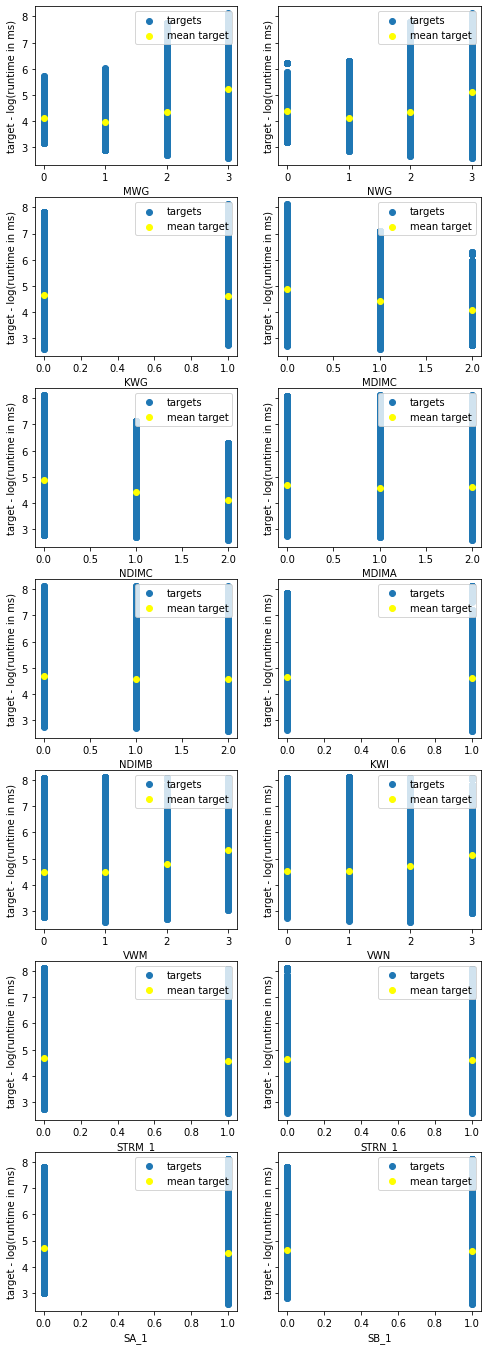

In [59]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(7,2,figsize = (8,24),sharey = True)
cols = data.columns
count = 0
for i in range(0,7):
    for j in range(0,2):
        ax[i,j].scatter(data[cols[count]],data['Run1 (ms)'])
        vals = data[cols[count]].unique()
        targ = [np.mean(data[data[cols[count]] == i]['Run1 (ms)']) for i in vals]
        ax[i,j].scatter(vals,targ,color = 'yellow')
        ax[i,j].set_ylabel('target - log(runtime in ms)')
        ax[i,j].set_xlabel(f'{cols[count]}')
        ax[i,j].legend(['targets', 'mean target'],loc = 1)
        count += 1

Here we are taking all possible permutations excluding some permutations that are not feasible due to kernel constraints,
but the ordinal values of each variable is equally present in the data.
<br><br>
Although the authors have recommended the logarithm of runtime, we still try to check for relations in the original runtime.

In [63]:
data1 = pd.read_csv("sgemm_product_dataset\sgemm_product.csv")
target = data1['Run1 (ms)']
data['original_tar'] = target

In [65]:
data.corr()['original_tar']

MWG             0.327254
NWG             0.295599
KWG             0.011508
MDIMC          -0.238265
NDIMC          -0.232198
MDIMA          -0.011056
NDIMB          -0.012603
KWI             0.032183
VWM             0.155545
VWN             0.137278
STRM_1         -0.012568
STRN_1         -0.000122
SA_1            0.052492
SB_1            0.064162
Run1 (ms)       0.809857
original_tar    1.000000
Name: original_tar, dtype: float64

Although the correlations are not great some of the independent variables are showing an upper limit in the target which is not visible in the logarithm target.

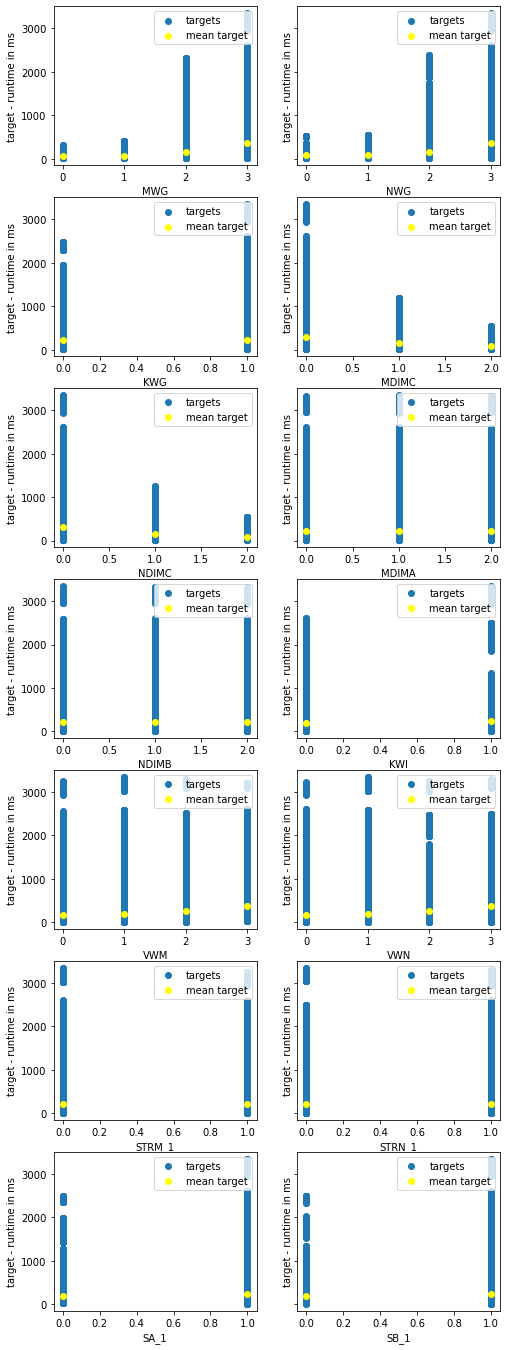

In [64]:
fig,ax = plt.subplots(7,2,figsize = (8,24),sharey = True)
cols = data.columns
count = 0
for i in range(0,7):
    for j in range(0,2):
        ax[i,j].scatter(data[cols[count]],data['original_tar'])
        vals = data[cols[count]].unique()
        targ = [np.mean(data[data[cols[count]] == i]['original_tar']) for i in vals]
        ax[i,j].scatter(vals,targ,color = 'yellow')
        ax[i,j].set_ylabel('target -> runtime in ms')
        ax[i,j].set_xlabel(f'{cols[count]}')
        ax[i,j].legend(['targets', 'mean target'],loc = 1)
        count += 1

---

### Saving data to a csv file

In [66]:
data.to_csv('preprocessed_data.csv')

### Conclusions
We will need more feature engineering and a non linear function to build an accurate prediction model for this data.